In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.widgets import Button, Slider

In [2]:
def PrecessionModel(limit,params):
    t0, period, e, omega_0, d_omega_dE = params
    t_tras = [np.nan]*limit
    omegas = [np.nan]*limit
    t_tras[0] = t0
    omegas[0] = omega_0
    P_ano = period/(1-d_omega_dE/(2*np.pi))
    for i in range(1,limit):
        omegas[i] = (omegas[i-1] + d_omega_dE) % (2*np.pi)
        t_tras[i] = t_tras[i-1] + period + e*P_ano/(np.pi)*d_omega_dE*np.sin(omegas[i])
    return t_tras

Model = PrecessionModel

In [3]:
data = pd.read_csv('t.csv')
data

,T_mid,Uncertainty,Label,Reference,Epoch
0,2.456514e+06,0.000100,Ground,2017A&A...604A.110A,0
1,2.457584e+06,0.000011,K2,2017MNRAS.469.1622M,187
2,2.457905e+06,0.000047,HST-Ma,Ma et al. 2024,243
3,2.457910e+06,0.000046,HST-Ma,Ma et al. 2024,244
4,2.458580e+06,0.000429,TESS-I&W,Ivshina & Winn 2022,361
5,2.458591e+06,0.000355,TESS-I&W,Ivshina & Winn 2022,363
6,2.459959e+06,0.000017,JWST,This Work,602
7,2.459964e+06,0.000011,JWST,This Work,603
8,2.460108e+06,0.000009,JWST,This Work,628
9,2.460119e+06,0.000015,JWST,This Work,630


In [4]:
times0_pre = data['T_mid'][0]
period_pre = 5.72148926
epochs = np.arange(data['Epoch'].max()+1)
t_lin = [times0_pre + e*period_pre for e in data['Epoch']]
t_lin_pre = np.arange(data['Epoch'].max()+1)*period_pre + times0_pre
e = 0.06
# omega_0 = 3.0159202786255075
# omega_0 = np.pi/2
omega_0 = 1.3
# d_omega_dE = 0.0005865415954191382
d_omega_dE = 9.7818846e-6
# d_omega_dE = 0

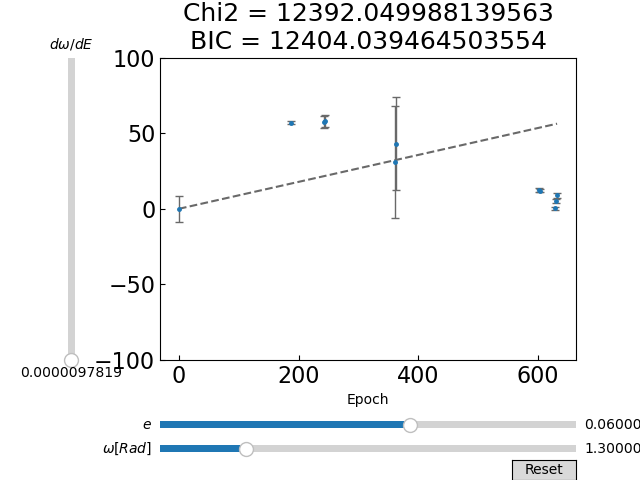

In [5]:
multi = 24*60*60
init_omega = omega_0
init_domega = d_omega_dE
init_e = e
params = [times0_pre,period_pre,init_e,init_omega,init_domega]
fig, ax = plt.subplots()
ax.errorbar(data['Epoch'],(data['T_mid']-t_lin)*multi,yerr=data['Uncertainty']*multi,fmt='.',label='data',ms=5,ecolor='dimgray',elinewidth=1,capsize=3)
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
t_pre = Model(data['Epoch'].max()+1,params)

k = len(params)
c=[]
for i in range(len(data['T_mid'])):
    c.append((data['T_mid'][i]-t_pre[data['Epoch'][i]])**2/data['Uncertainty'][i]**2)
c=np.array(c)
chi2 = c.sum()
BIC = chi2+k*np.log(len(data['T_mid']))

line, = ax.plot(epochs,(t_pre-t_lin_pre)*multi,ls='--',color='dimgray',lw=1.5)
ax.set_ylim(-100,100)
ax.set_xlabel('Epoch')
ax.set_title('Chi2 = '+str(chi2)+'\nBIC = '+str(BIC), fontsize=18)
fig.subplots_adjust(left=0.25, bottom=0.25)

axomega = fig.add_axes([0.25, 0.05, 0.65, 0.03])
omega_slider = Slider(
    ax=axomega,
    label=r'$\omega[Rad]$',
    valmin=0.0,
    valmax=2*np.pi,
    valinit=init_omega,
    valfmt='%.6f',
    valstep=0.00001
)

axe = fig.add_axes([0.25, 0.1, 0.65, 0.03])
allowed_es = np.linspace(0,1,100000)
e_slider = Slider(
    ax=axe,
    label=r'$e$',
    valmin=1e-6,
    valmax=1e-1,
    valinit=init_e,
    valfmt='%.6f',
    valstep=allowed_es
)

axdomega = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
domega_slider = Slider(
    ax=axdomega,
    label=r"$d\omega/dE$",
    valmin=1e-6,
    valmax=1e-2,
    valinit=init_domega,
    valfmt='%.10f',
    orientation="vertical",
)

def update(val):
    params = [times0_pre,period_pre,e_slider.val,omega_slider.val,domega_slider.val]
    t_pre = Model(data['Epoch'].max()+1,params)
    line.set_ydata((t_pre-t_lin_pre)*multi)
    fig.canvas.draw_idle()
    c=[]
    for i in range(len(data['T_mid'])):
        c.append((data['T_mid'][i]-t_pre[data['Epoch'][i]])**2/data['Uncertainty'][i]**2)
    c=np.array(c)
    chi2 = c.sum()
    BIC = chi2+k*np.log(len(data['T_mid']))
    ax.set_title('Chi2 = '+str(chi2)+'\nBIC = '+str(BIC), fontsize=18)# adjust the main plot to make room for the sliders

omega_slider.on_changed(update)
domega_slider.on_changed(update)
e_slider.on_changed(update)

resetax = fig.add_axes([0.8, 0.001, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    omega_slider.reset()
    domega_slider.reset()
    e_slider.reset()
button.on_clicked(reset)
plt.show()